# Explorig the effects of zeros in OscoNet


In [1]:
%matplotlib inline
from OscopeBootstrap import qvalue
from OscopeBootstrap.create_edge_network_represention import create_edge_network_representation
from OscopeBootstrap.SyntheticDataset import GetSimISyntheticData, true_adj_matrix
from OscopeBootstrap.oscope_tf import bootstrap_hypothesis_test, get_accuracy, get_metrics_for_different_qvalue_thresholds2, get_metrics_for_different_qvalue_thresholds
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from typing import Tuple



In [2]:
def GetSimZeros(NG: int = 15, G: int = 1000, N: int = 100, noiseLevel: int = 0,a: float =0.05, ngroups: int = 3) \
        -> Tuple[pd.DataFrame, np.ndarray, np.ndarray]:
    sigma_strLevel = [0.05, 0.1, 0.2, 0.3, 0.4, 0.6]
    sigma_str = sigma_strLevel[noiseLevel]

    data = np.zeros((G, N))
    data[:] = np.nan
    # genes per weak/strong oscillatory group
    # Group 1
    cellName = []
    for i in range(N):
        cellName.append('C'+str(i))

    geneName = []

    phaseG = np.zeros((G))
    angularSpeed = np.zeros((G))
    #a=0.01#percentage of zeros desired. Setting for No zero inflation is a=0.05, l=0.1
    l=0.1
    nn=round(a*N)
    mm1=round((N-nn)/2)
    if  ((nn % 2) == 0):
        mm2=mm1
    else:
        mm2=mm1+1
    nz=round(NG*0.8)
    t1 = np.linspace(0, 2*np.pi, N)
    t2 = np.random.permutation(t1)


    for i in range(nz):  # strong oscillators with zeros
        startingPhase = np.random.uniform(0, 2*np.pi)
        phaseG[i] = startingPhase
        angularSpeed[i] = 2
        data[i, :] = np.sin(2*t1 + startingPhase) #+ sigma_str*np.random.randn(N)
        geneName.append('G1SO'+str(i))
        j0=np.random.randint(N-1, size=nn)
        data[i,j0]=-1
        data[i,:]= data[i,:] + sigma_str*np.random.randn(N)
    for i in range(nz, NG):  # strong oscillators without zeros
        t1 = np.linspace(0, 2*np.pi, N)
        startingPhase = np.random.uniform(0, 2*np.pi)
        phaseG[i] = startingPhase
        angularSpeed[i] = 2
        data[i, :] = np.sin(2*t1 + startingPhase) + sigma_str*np.random.randn(N)
        geneName.append('G1SO'+str(i))
    for i in range(NG, NG+nz):  # weak oscillators with zeros
        startingPhase = np.random.uniform(0, 2*np.pi)
        phaseG[i] = startingPhase
        angularSpeed[i] = 2
        data[i, :] = np.sin(2*t1 + startingPhase) #+ 2*sigma_str*np.random.randn(N)
        geneName.append('G1WO'+str(i))
        j0=np.random.randint(N-1, size=nn)
        data[i,j0]=-1
        data[i,:]= data[i,:] + 2*sigma_str*np.random.randn(N)
    for i in range(NG+nz, 2*NG):  # weak oscillators without zeros
        t1 = np.linspace(0, 2*np.pi, N)
        startingPhase = np.random.uniform(0, 2*np.pi)
        phaseG[i] = startingPhase
        angularSpeed[i] = 2
        data[i, :] = np.sin(2*t1 + startingPhase) + 2*sigma_str*np.random.randn(N)
        geneName.append('G1WO'+str(i))
    if(ngroups >= 2):
        # Group 2
        #t2=np.linspace(0, 2*np.pi, N)
        for i in range(2*NG, 2*NG+nz):  # strong oscillators with zeros
            startingPhase = np.random.uniform(0, 2*np.pi)
            phaseG[i] = startingPhase
            angularSpeed[i] = 3
            data[i, :] = np.sin(3*t2 + startingPhase) 
            geneName.append('G2SO'+str(i))
            j0=np.random.randint(N-1, size=nn)
            data[i,j0]=-1
            data[i,:]= data[i,:] + sigma_str*np.random.randn(N)
        for i in range(2*NG+nz, 3*NG):  # strong oscillators without zeros
            startingPhase = np.random.uniform(0, 2*np.pi)
            phaseG[i] = startingPhase
            angularSpeed[i] = 3
            data[i, :] = np.sin(3*t2 + startingPhase) + sigma_str*np.random.randn(N)
            geneName.append('G2SO'+str(i))
        for i in range(3*NG, 3*NG+nz):  # weak oscillators with zeros
            startingPhase = np.random.uniform(0, 2*np.pi)
            phaseG[i] = startingPhase
            angularSpeed[i] = 3
            data[i, :] = np.sin(3*t2 + startingPhase)
            geneName.append('G2WO'+str(i))
            j0=np.random.randint(N-1, size=nn)
            data[i,j0]=-1
            data[i, :] = data[i, :] + 2*sigma_str*np.random.randn(N)
        for i in range(3*NG+nz, 4*NG):  # weak oscillators without zeros
            startingPhase = np.random.uniform(0, 2*np.pi)
            phaseG[i] = startingPhase
            angularSpeed[i] = 3
            data[i, :] = np.sin(3*t2 + startingPhase) + 2*sigma_str*np.random.randn(N)
            geneName.append('G2WO'+str(i))
  # white noise genes
    for w in range(i+1, G):  # use i index from above where it stopped
        phaseG[w] = np.nan
        angularSpeed[w] = np.nan
        data[w, :] = np.max([3/2 * sigma_str, 1]) * np.random.randn(N)
        geneName.append('R'+str(w))
    assert np.all(~ np.isnan(data)), 'Entries with nans!'
    assert len(geneName) == G
    assert len(cellName) == N
    df = pd.DataFrame(data, index=geneName, columns=cellName)
    return df, phaseG, angularSpeed




### Create a synthetic dataset containing one group of co-oscillating genes and vary the percentage of zeros in the original data (this corresponds to the number of -1 in the sinusoidal data)

/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


find_best_psi_for_each_gene_pair 2 secs
get_permuted_cost 6 secs
get_pvalues 0 secs
qvalues pi0=0.790, estimated proportion of null features 
Ratio of correctly identified pairs 0.99
True positive rate 1.00, False discovery rate 0.06
find_best_psi_for_each_gene_pair 0 secs


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


get_permuted_cost 4 secs
get_pvalues 0 secs
qvalues pi0=0.882, estimated proportion of null features 
Ratio of correctly identified pairs 0.99
True positive rate 1.00, False discovery rate 0.03
find_best_psi_for_each_gene_pair 0 secs


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


get_permuted_cost 4 secs
get_pvalues 0 secs
qvalues pi0=0.758, estimated proportion of null features 
Ratio of correctly identified pairs 0.99
True positive rate 1.00, False discovery rate 0.03
find_best_psi_for_each_gene_pair 0 secs


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


get_permuted_cost 4 secs
get_pvalues 0 secs
qvalues pi0=0.911, estimated proportion of null features 
Ratio of correctly identified pairs 0.98
True positive rate 0.99, False discovery rate 0.08
find_best_psi_for_each_gene_pair 0 secs


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


get_permuted_cost 4 secs
get_pvalues 0 secs
qvalues pi0=0.654, estimated proportion of null features 
Ratio of correctly identified pairs 0.99
True positive rate 0.98, False discovery rate 0.04
find_best_psi_for_each_gene_pair 0 secs


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


get_permuted_cost 4 secs
get_pvalues 0 secs
qvalues pi0=0.758, estimated proportion of null features 
Ratio of correctly identified pairs 0.98
True positive rate 0.92, False discovery rate 0.05


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


find_best_psi_for_each_gene_pair 0 secs
get_permuted_cost 4 secs
get_pvalues 0 secs
qvalues pi0=0.792, estimated proportion of null features 
Ratio of correctly identified pairs 0.97
True positive rate 0.86, False discovery rate 0.05
find_best_psi_for_each_gene_pair 0 secs


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


get_permuted_cost 4 secs
get_pvalues 0 secs
qvalues pi0=0.883, estimated proportion of null features 
Ratio of correctly identified pairs 0.96
True positive rate 0.82, False discovery rate 0.04
find_best_psi_for_each_gene_pair 0 secs


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


get_permuted_cost 4 secs
get_pvalues 0 secs
qvalues pi0=1.014, estimated proportion of null features 
got pi0 > 1 (1.014) while estimating qvalues, setting it to 1
Ratio of correctly identified pairs 0.95
True positive rate 0.75, False discovery rate 0.07
find_best_psi_for_each_gene_pair 0 secs


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


get_permuted_cost 4 secs
get_pvalues 0 secs
qvalues pi0=0.968, estimated proportion of null features 
Ratio of correctly identified pairs 0.95
True positive rate 0.76, False discovery rate 0.06
find_best_psi_for_each_gene_pair 0 secs


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


get_permuted_cost 4 secs
get_pvalues 0 secs
qvalues pi0=0.940, estimated proportion of null features 
Ratio of correctly identified pairs 0.94
True positive rate 0.74, False discovery rate 0.08
find_best_psi_for_each_gene_pair 0 secs


<ipython-input-3-9504e7c87db2>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(3, sharex=True, sharey=True)
<ipython-input-3-9504e7c87db2>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, 2, figsize=(20, 7))
/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


get_permuted_cost 4 secs
get_pvalues 0 secs
qvalues pi0=0.915, estimated proportion of null features 
Ratio of correctly identified pairs 0.94
True positive rate 0.68, False discovery rate 0.05
find_best_psi_for_each_gene_pair 0 secs


<ipython-input-3-9504e7c87db2>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(3, sharex=True, sharey=True)
<ipython-input-3-9504e7c87db2>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, 2, figsize=(20, 7))
/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


get_permuted_cost 4 secs
get_pvalues 0 secs
qvalues pi0=1.148, estimated proportion of null features 
got pi0 > 1 (1.148) while estimating qvalues, setting it to 1
Ratio of correctly identified pairs 0.91
True positive rate 0.53, False discovery rate 0.09
find_best_psi_for_each_gene_pair 0 secs


<ipython-input-3-9504e7c87db2>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(3, sharex=True, sharey=True)
<ipython-input-3-9504e7c87db2>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, 2, figsize=(20, 7))
/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


get_permuted_cost 4 secs
get_pvalues 0 secs
qvalues pi0=1.368, estimated proportion of null features 
got pi0 > 1 (1.368) while estimating qvalues, setting it to 1
Ratio of correctly identified pairs 0.90
True positive rate 0.46, False discovery rate 0.09
find_best_psi_for_each_gene_pair 0 secs


<ipython-input-3-9504e7c87db2>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(3, sharex=True, sharey=True)
<ipython-input-3-9504e7c87db2>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, 2, figsize=(20, 7))
/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


get_permuted_cost 4 secs
get_pvalues 0 secs
qvalues pi0=1.306, estimated proportion of null features 
got pi0 > 1 (1.306) while estimating qvalues, setting it to 1
Ratio of correctly identified pairs 0.89
True positive rate 0.42, False discovery rate 0.12
find_best_psi_for_each_gene_pair 0 secs


<ipython-input-3-9504e7c87db2>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(3, sharex=True, sharey=True)
<ipython-input-3-9504e7c87db2>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, 2, figsize=(20, 7))
/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


get_permuted_cost 4 secs
get_pvalues 0 secs
qvalues pi0=1.348, estimated proportion of null features 
got pi0 > 1 (1.348) while estimating qvalues, setting it to 1
Ratio of correctly identified pairs 0.88
True positive rate 0.39, False discovery rate 0.10
find_best_psi_for_each_gene_pair 0 secs


<ipython-input-3-9504e7c87db2>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(3, sharex=True, sharey=True)
<ipython-input-3-9504e7c87db2>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, 2, figsize=(20, 7))
/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


get_permuted_cost 5 secs
get_pvalues 0 secs
qvalues pi0=1.366, estimated proportion of null features 
got pi0 > 1 (1.366) while estimating qvalues, setting it to 1
Ratio of correctly identified pairs 0.88
True positive rate 0.36, False discovery rate 0.10
find_best_psi_for_each_gene_pair 0 secs


<ipython-input-3-9504e7c87db2>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(3, sharex=True, sharey=True)
<ipython-input-3-9504e7c87db2>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, 2, figsize=(20, 7))
/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


get_permuted_cost 4 secs
get_pvalues 0 secs
qvalues pi0=1.324, estimated proportion of null features 
got pi0 > 1 (1.324) while estimating qvalues, setting it to 1
Ratio of correctly identified pairs 0.87
True positive rate 0.31, False discovery rate 0.12


<ipython-input-3-9504e7c87db2>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(3, sharex=True, sharey=True)
<ipython-input-3-9504e7c87db2>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, 2, figsize=(20, 7))
/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


find_best_psi_for_each_gene_pair 0 secs
get_permuted_cost 4 secs
get_pvalues 0 secs
qvalues pi0=1.273, estimated proportion of null features 
got pi0 > 1 (1.273) while estimating qvalues, setting it to 1
Ratio of correctly identified pairs 0.88
True positive rate 0.33, False discovery rate 0.11


<ipython-input-3-9504e7c87db2>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(3, sharex=True, sharey=True)
<ipython-input-3-9504e7c87db2>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, 2, figsize=(20, 7))
/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


find_best_psi_for_each_gene_pair 0 secs
get_permuted_cost 4 secs
get_pvalues 0 secs
qvalues pi0=1.319, estimated proportion of null features 
got pi0 > 1 (1.319) while estimating qvalues, setting it to 1
Ratio of correctly identified pairs 0.86
True positive rate 0.24, False discovery rate 0.18


<ipython-input-3-9504e7c87db2>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(3, sharex=True, sharey=True)
<ipython-input-3-9504e7c87db2>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, 2, figsize=(20, 7))


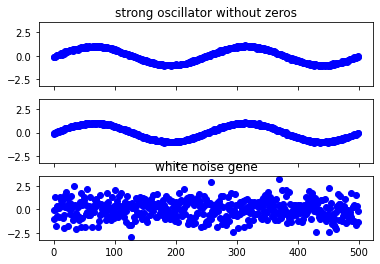

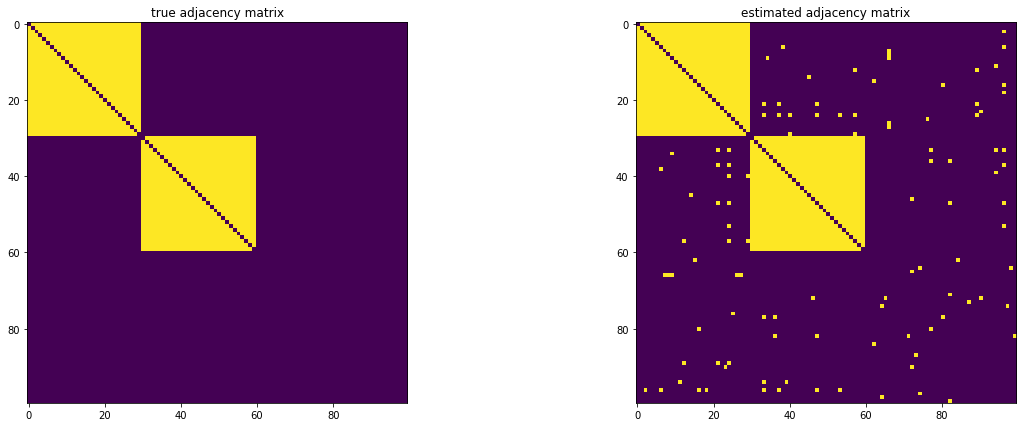

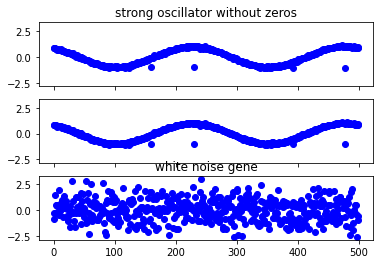

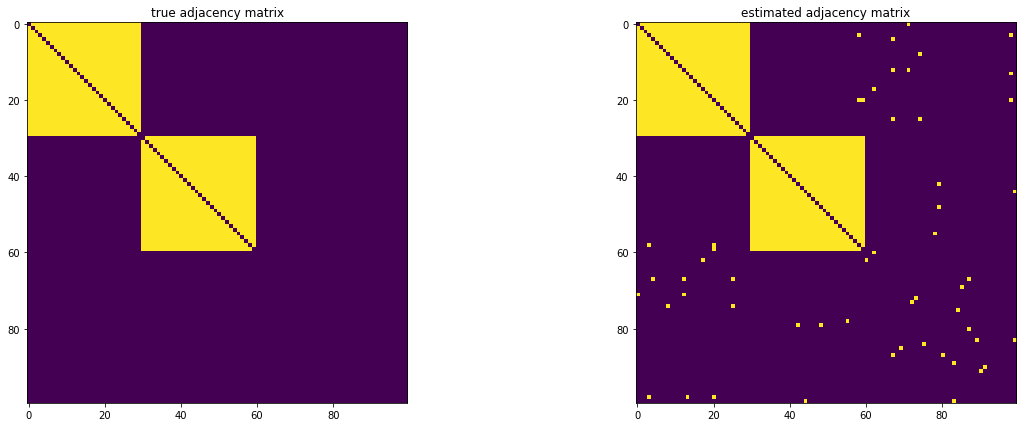

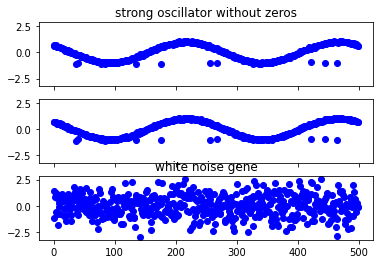

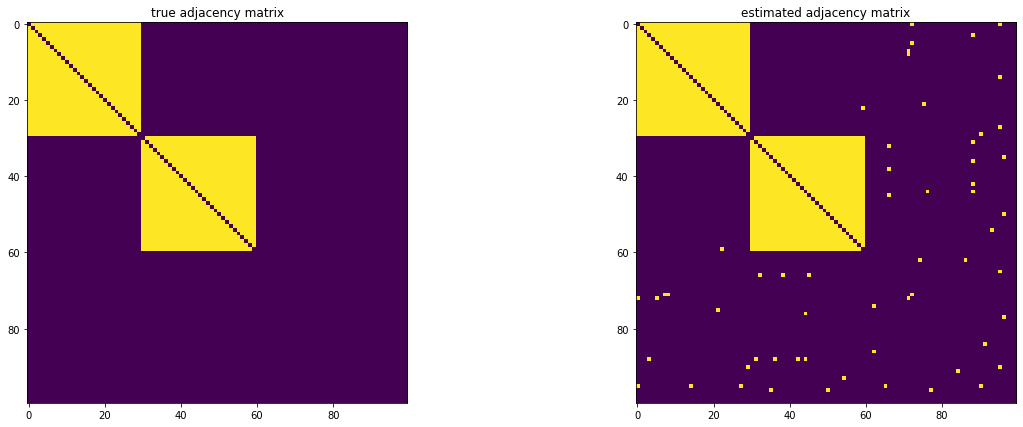

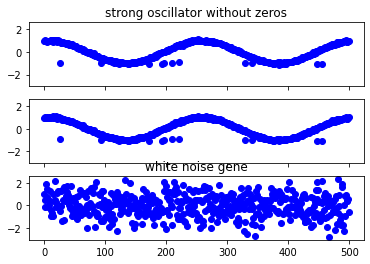

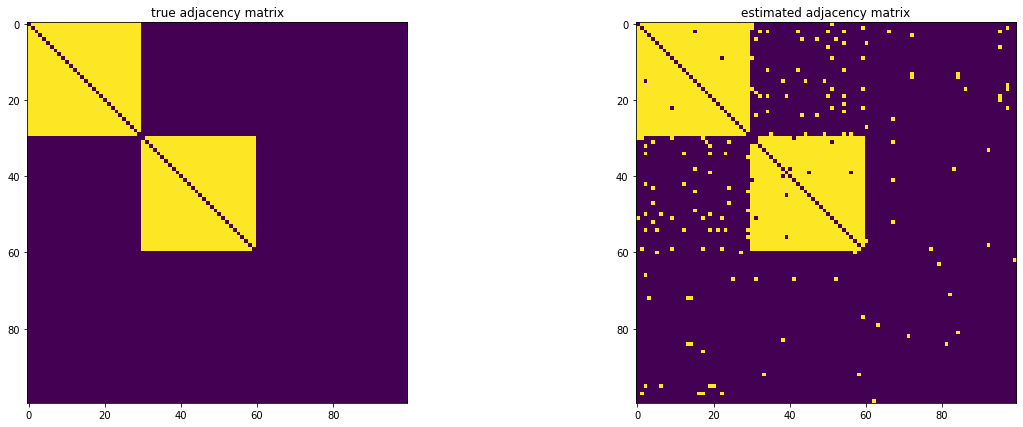

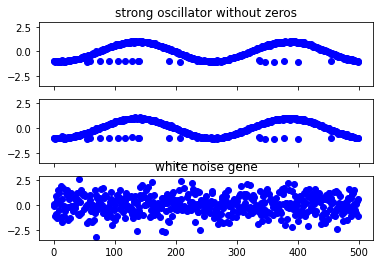

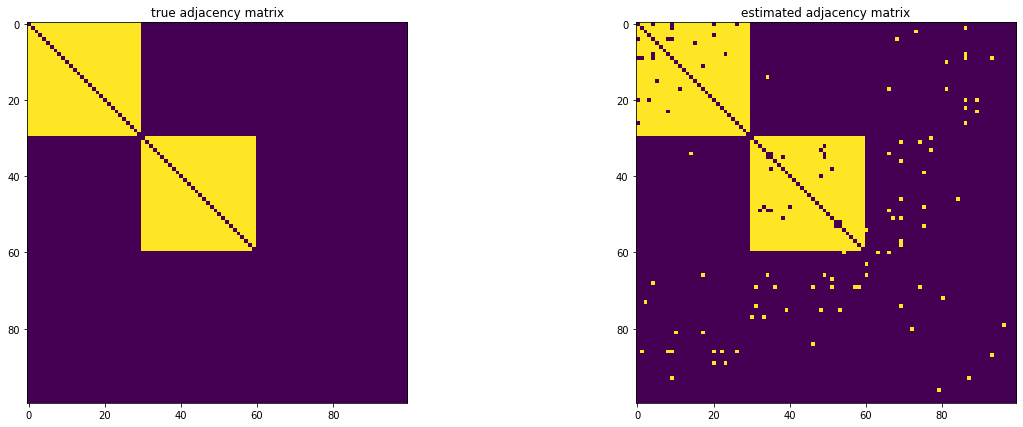

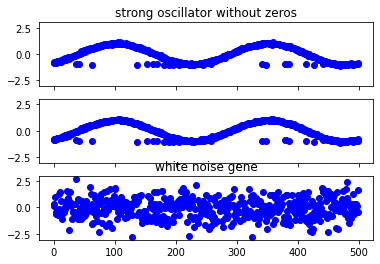

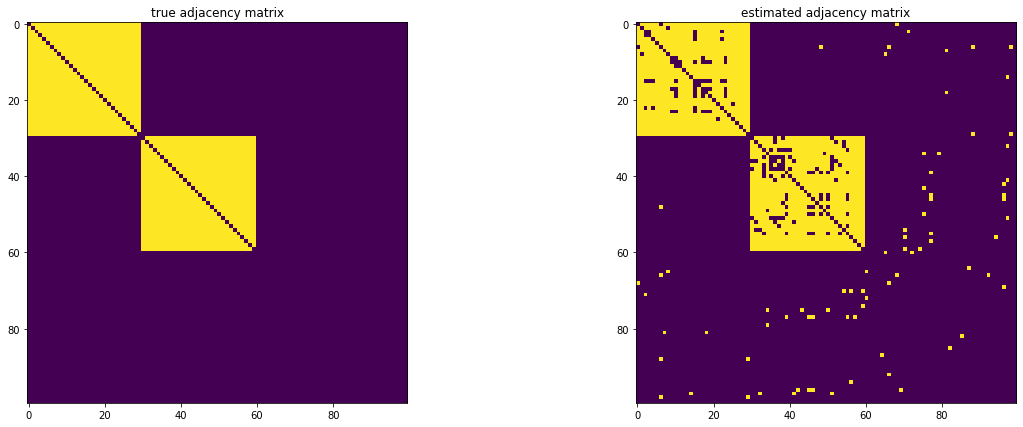

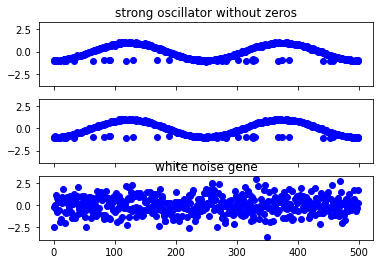

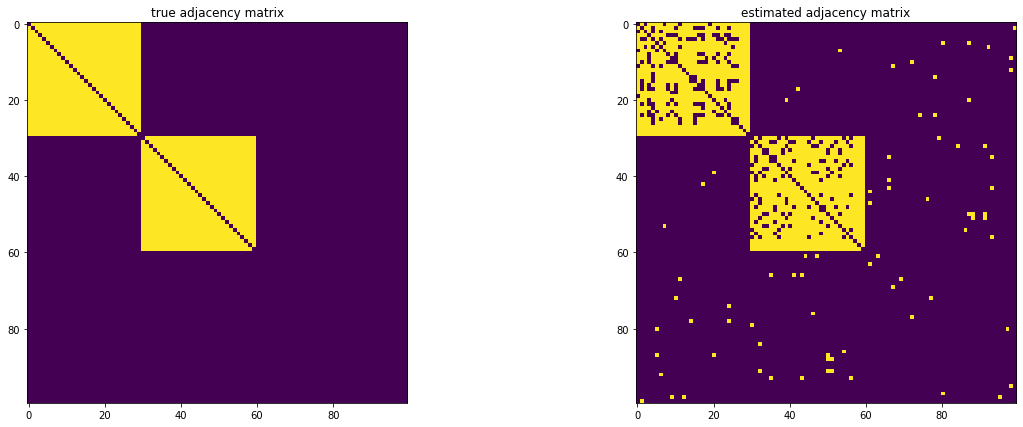

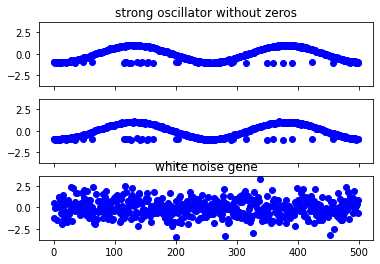

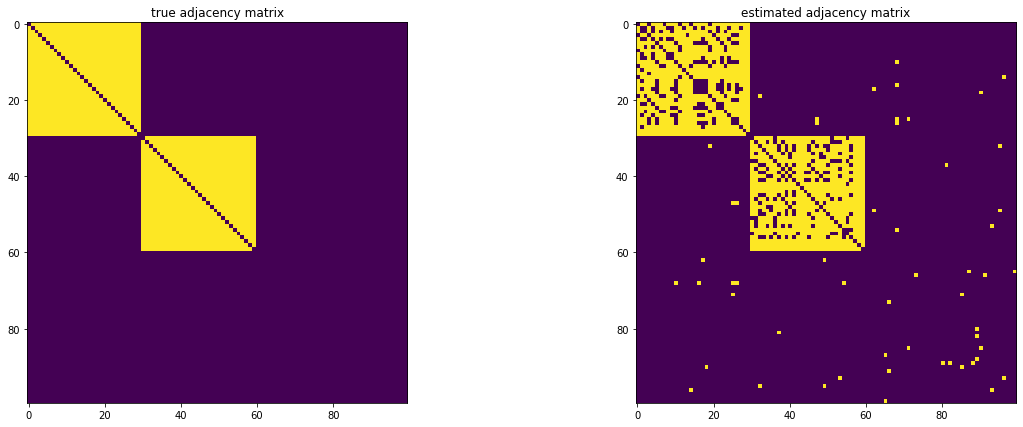

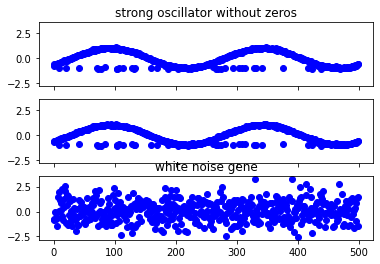

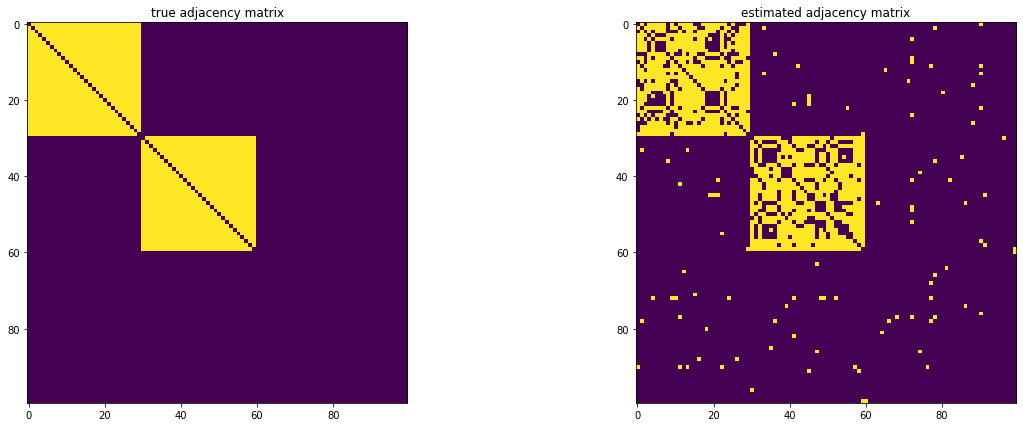

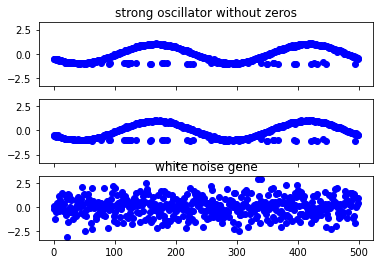

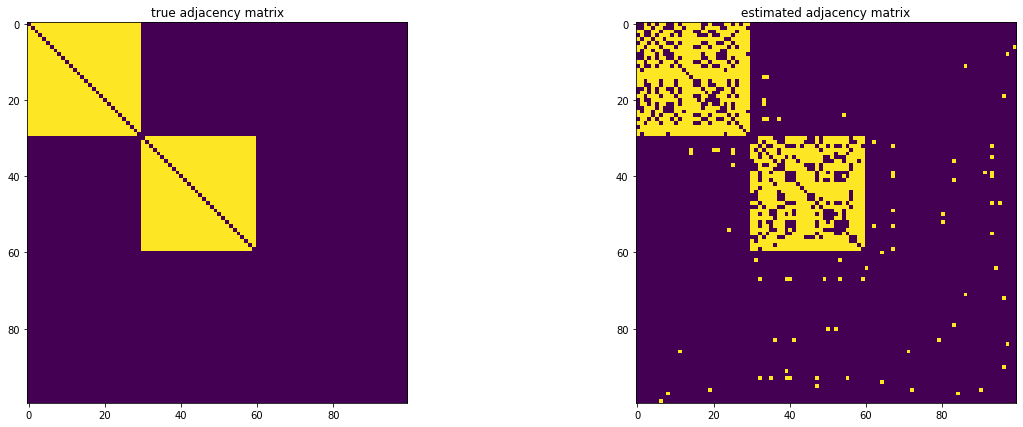

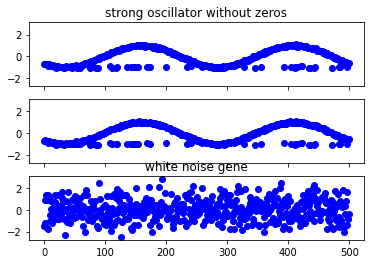

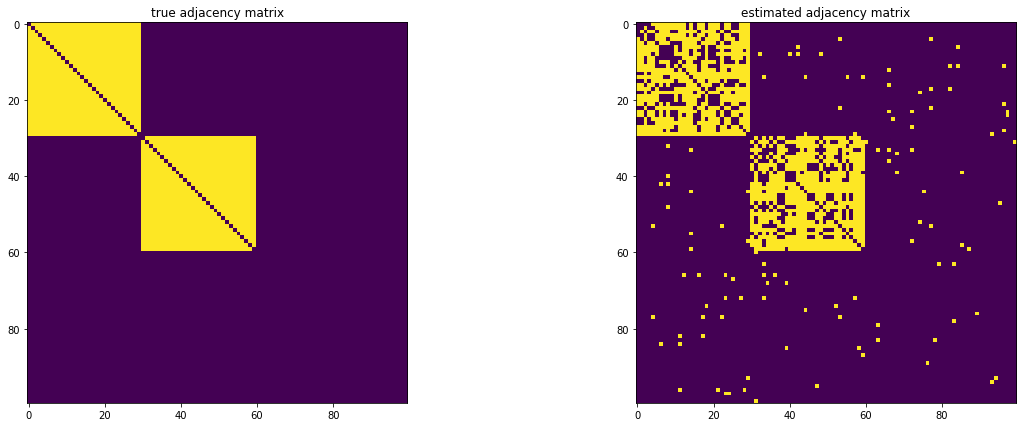

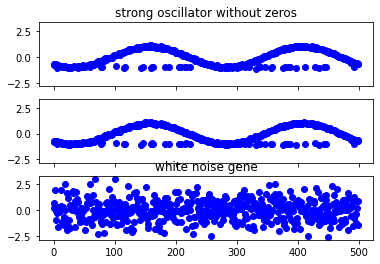

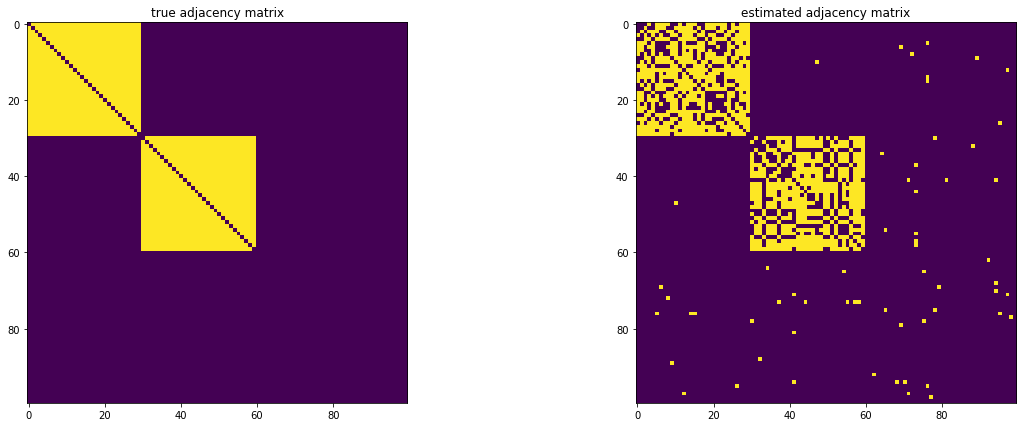

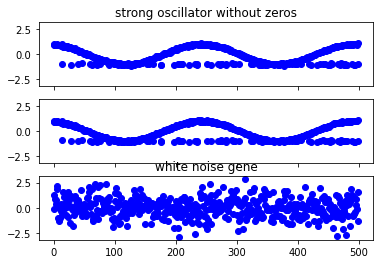

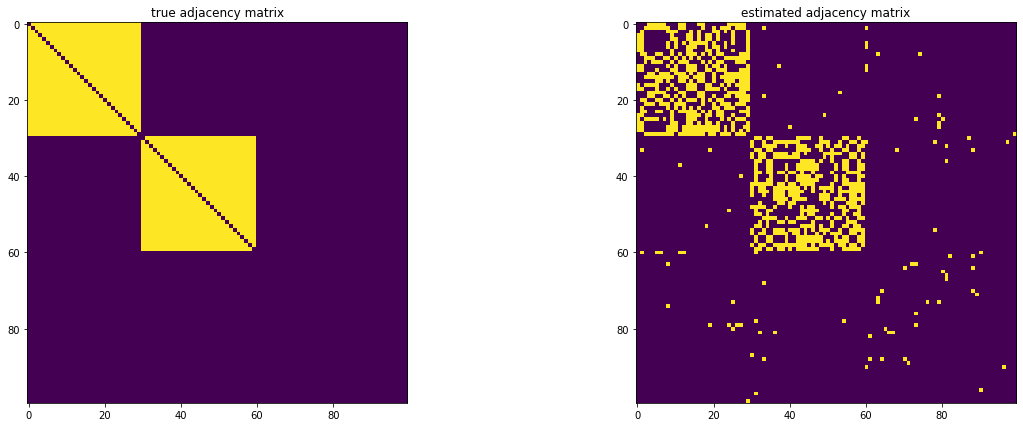

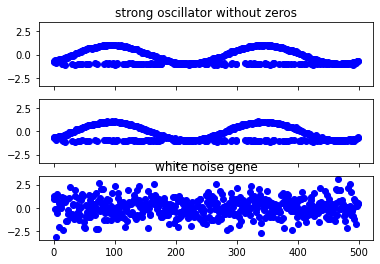

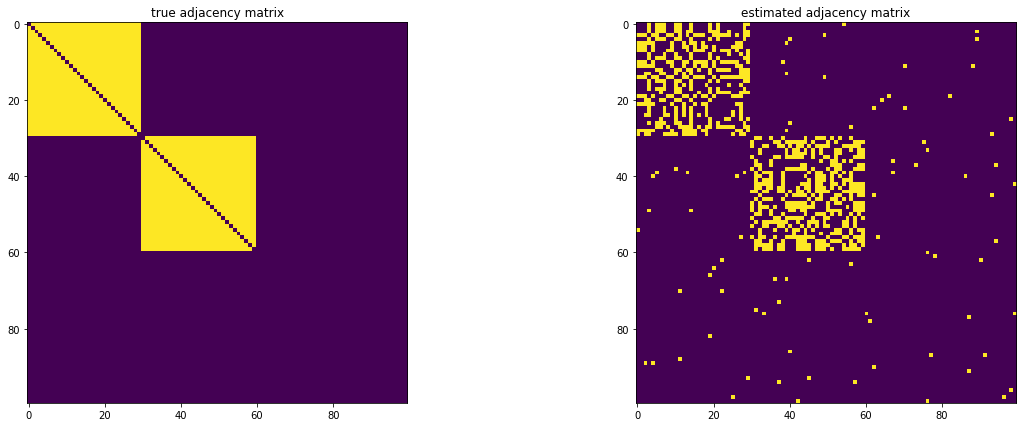

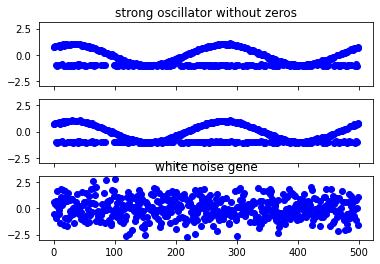

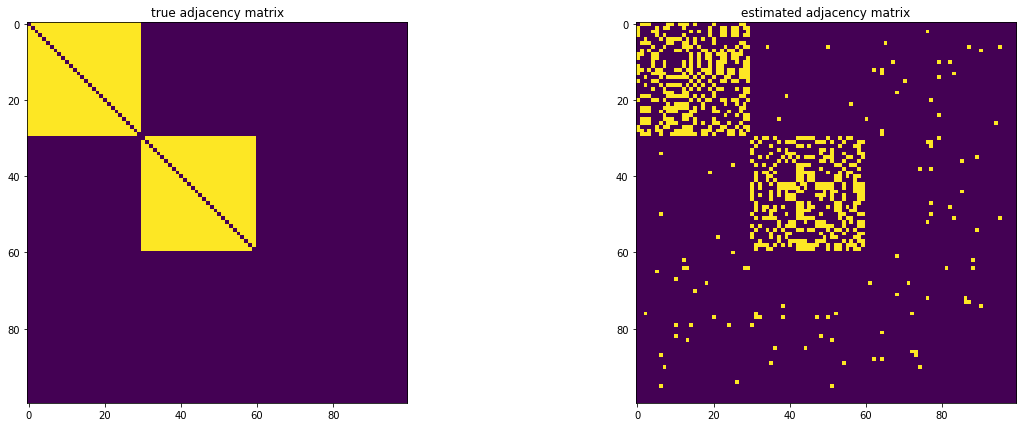

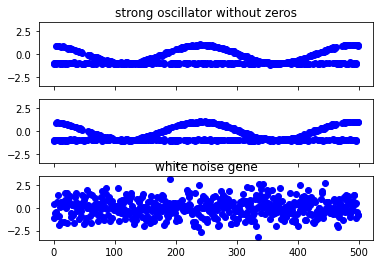

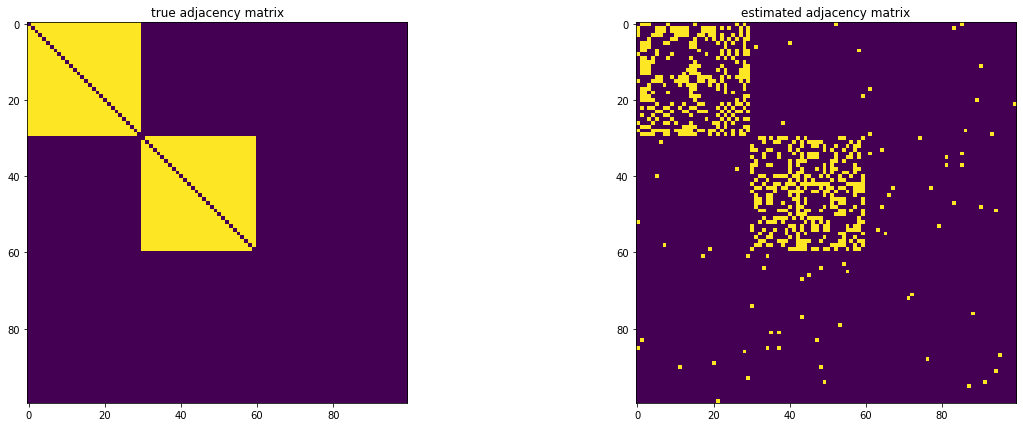

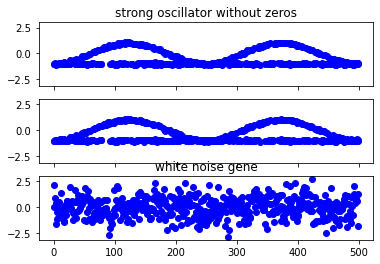

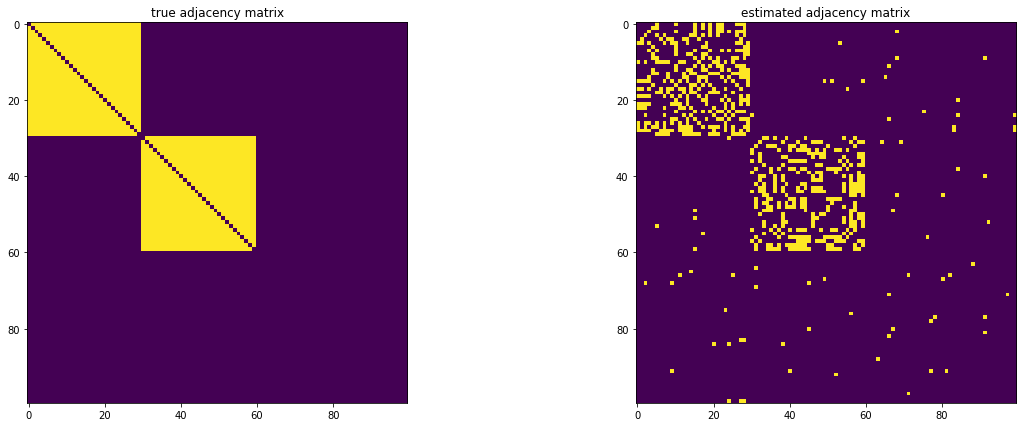

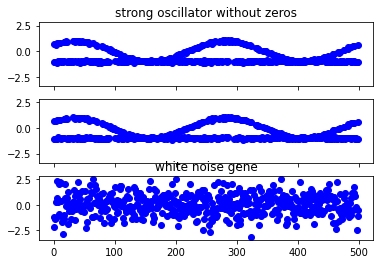

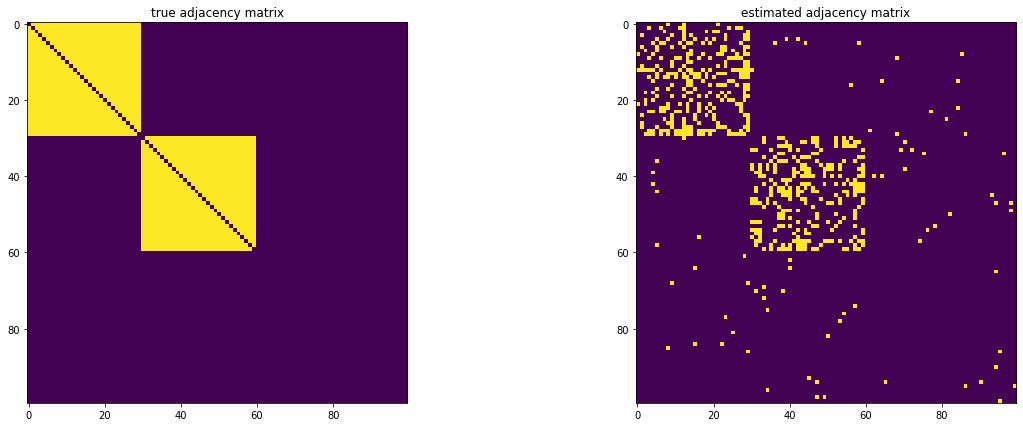

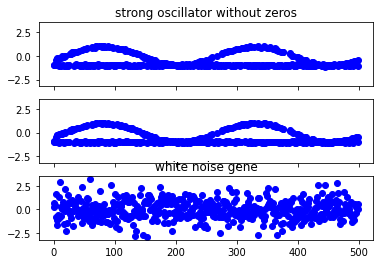

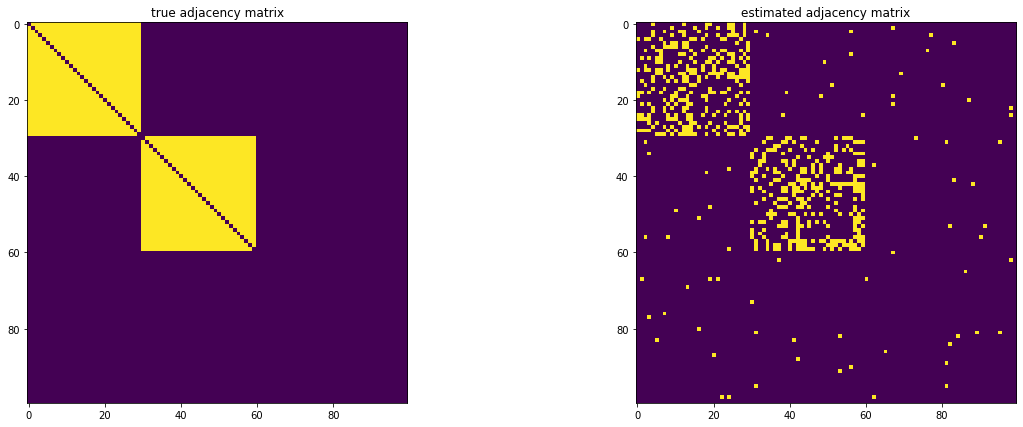

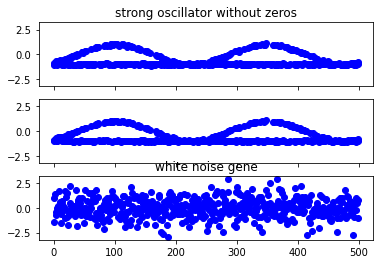

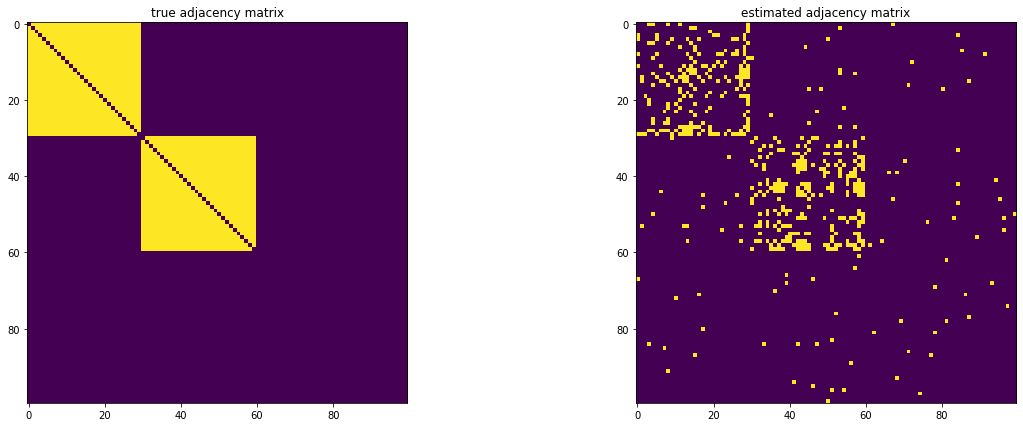

In [3]:
NG = 15  # half gene cluster size so we have a total of 10 co-oscillating genes  
G = 100  # number of genes
N = 500 # cells
ngroups = 2 # num of cluster
n_bootstrap = 100  # number of bootstrap samples
grid_points_in_search = 10  # grid size for phase shift parameter estimation., 
alpha = 0.001  # significance level
a=[0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.08,0.09,0.1,0.2,0.3,0.5,0.6,0.7,0.8,0.9,1]
correct_ratio = np.zeros(len(a))
TPR = np.zeros(len(a))
FDR = np.zeros(len(a))
TP = np.zeros(len(a))
TN = np.zeros(len(a))
FP = np.zeros(len(a))
FN = np.zeros(len(a))
FPR = np.zeros(len(a))


for i in range(len(a)):
    data_df, phaseG, angularSpeed = GetSimZeros(NG=NG, G=G, N=N, noiseLevel=0,a=a[i], ngroups= ngroups)
    adjacency_matrix_true = true_adj_matrix(G, angularSpeed)  # True adjacency matrix
    adjacency_matrix, qvalues, cost_matrix = bootstrap_hypothesis_test(n_bootstrap, data_df.values, alpha=alpha,
                                                            grid_points_in_search=grid_points_in_search)
    correct_ratio[i] = get_accuracy(adjacency_matrix, adjacency_matrix_true)
    print(f'Ratio of correctly identified pairs {correct_ratio[i]:.2f}')
    TPR[i], FDR[i], FPR[i], TP[i], TN[i], FP[i], FN[i] = get_metrics_for_different_qvalue_thresholds2(qvalues, adjacency_matrix_true, np.array([alpha]))
    TPR[i], FDR[i], _ = get_metrics_for_different_qvalue_thresholds(qvalues, adjacency_matrix_true, np.array([alpha]))
    print(f'True positive rate {float(TPR[i]):.2f}, False discovery rate {float(FDR[i]):.2f}')
    _, ax = plt.subplots(3, sharex=True, sharey=True)
    ax[0].plot(np.arange(N), data_df.iloc[0, :], 'bo'); ax[0].set_title('strong oscillator with zeros')
    ax[1].plot(np.arange(N), data_df.iloc[0, :], 'bo'); ax[0].set_title('strong oscillator without zeros')
    ax[2].plot(np.arange(N), data_df.iloc[4*NG, :], 'bo'); ax[2].set_title('white noise gene')
    
    _, ax = plt.subplots(1, 2, figsize=(20, 7))
    ax[0].imshow(adjacency_matrix_true); ax[0].set_title('true adjacency matrix')
    ax[1].imshow(adjacency_matrix); ax[1].set_title('estimated adjacency matrix')

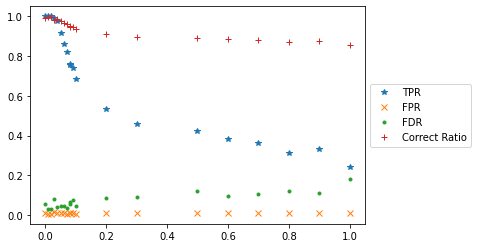

In [4]:
plt.plot(a,TPR,'*',label='TPR')
plt.plot(a,FPR,'x',label='FPR')

plt.plot(a,FDR,'.',label='FDR')
plt.plot(a,correct_ratio,'+',label='Correct Ratio');

legend_x = 1
legend_y = 0.5
plt.legend(loc='center left', bbox_to_anchor=(legend_x, legend_y))
#
#plt.legend(loc='center left', frameon=True)


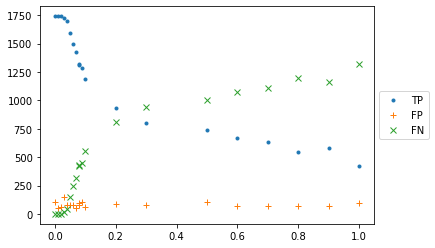

In [5]:
#plt.plot(a,TN,'*',label='TN')
plt.plot(a,TP,'.',label='TP')
plt.plot(a,FP,'+',label='FP')
plt.plot(a,FN,'x',label='FN')

legend_x = 1
legend_y = 0.5
plt.legend(loc='center left', bbox_to_anchor=(legend_x, legend_y))


In [18]:
print('TPR=',TPR)
print('FDR=',FDR)
print('correct_ratio=',correct_ratio)

TPR= [1.         1.         1.         1.         1.         0.99885057
 0.98965517 0.9954023  0.97471264 0.98850575 0.97816092 0.95287356
 0.89425287 0.87011494 0.86091954 0.85172414 0.85862069 0.84942529
 0.85172414 0.85172414]
FDR= [0.04500549 0.05434783 0.03010033 0.03867403 0.04079383 0.04923414
 0.10869565 0.03884573 0.05567929 0.05181918 0.05966851 0.04822044
 0.05237515 0.06658446 0.04828463 0.03641092 0.03612903 0.02890933
 0.04755784 0.04139715]
correct_ratio= [0.99171717 0.98989899 0.99454545 0.99292929 0.99252525 0.99070707
 0.9769697  0.99212121 0.98545455 0.98848485 0.98525253 0.98323232
 0.97272727 0.96626263 0.96787879 0.96828283 0.96949495 0.96909091
 0.96646465 0.96747475]


In [19]:
print('TP=',TP)
print('FP=',FP)
print('TN=',TN)
print('FN=',FN)
print('TP+FP=',TP+FP)
print('FN+TN=',FN+TN)

TP= [1740. 1740. 1740. 1740. 1740. 1738. 1722. 1732. 1696. 1720. 1702. 1658.
 1556. 1514. 1498. 1482. 1494. 1478. 1482. 1482.]
FP= [ 82. 100.  54.  70.  74.  90. 210.  70. 100.  94. 108.  84.  86. 108.
  76.  56.  56.  44.  74.  64.]
TN= [8178. 8160. 8206. 8190. 8186. 8170. 8050. 8190. 8160. 8166. 8152. 8176.
 8174. 8152. 8184. 8204. 8204. 8216. 8186. 8196.]
FN= [  0.   0.   0.   0.   0.   2.  18.   8.  44.  20.  38.  82. 184. 226.
 242. 258. 246. 262. 258. 258.]
TP+FP= [1822. 1840. 1794. 1810. 1814. 1828. 1932. 1802. 1796. 1814. 1810. 1742.
 1642. 1622. 1574. 1538. 1550. 1522. 1556. 1546.]
FN+TN= [8178. 8160. 8206. 8190. 8186. 8172. 8068. 8198. 8204. 8186. 8190. 8258.
 8358. 8378. 8426. 8462. 8450. 8478. 8444. 8454.]


In [662]:
# considering a -1,1 conversion the zeros (min) will go towars -1 . Consider [min,-0.985] as 0 range
#np.shape(np.where(x<-0.985))[1] #number of zeros if uniformly sampled in N=1000 cells are ~55 so ~5%
#we could increse the observations in [min,-0.985] to see the effects of zeros. This means that instead of:
#    t1 = np.linspace(0, 2*np.pi, N)
# we could use more dense sampling around 3/2*np.pi:
#a=0.001#percentage of zeros desired
#nn=round(a*N)
#t0 = np.linspace( 3/2*np.pi-0.2, 3/2*np.pi+0.2,nn)
#mm=round((1-a)*N/2)
#t1b0=np.linspace( 0, 3/2*np.pi-0.2,mm)
#t1a0=np.linspace( 3/2*np.pi+0.2,2*np.pi,mm)
#t1=np.concatenate((t1b0, t0,t1a0), axis=None)
#t1.shape

# Consider now only high percentage of zeros between 0 and 0.4

In [44]:
a

array([0.01879644, 0.02335595, 0.08297834, 0.09844622, 0.26595422,
       0.28702205, 0.31794262, 0.36343447, 0.42402462, 0.42611653])

/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


find_best_psi_for_each_gene_pair 0 secs
get_permuted_cost 1 secs
get_pvalues 0 secs
qvalues pi0=0.818, estimated proportion of null features 
Ratio of correctly identified pairs 0.98
True positive rate 1.00, False discovery rate 0.05
find_best_psi_for_each_gene_pair 0 secs


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


get_permuted_cost 1 secs
get_pvalues 0 secs
qvalues pi0=1.030, estimated proportion of null features 
got pi0 > 1 (1.030) while estimating qvalues, setting it to 1
Ratio of correctly identified pairs 0.93
True positive rate 0.82, False discovery rate 0.06
find_best_psi_for_each_gene_pair 0 secs


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


get_permuted_cost 1 secs
get_pvalues 0 secs
qvalues pi0=0.879, estimated proportion of null features 
Ratio of correctly identified pairs 0.92
True positive rate 0.77, False discovery rate 0.03
find_best_psi_for_each_gene_pair 0 secs


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


get_permuted_cost 1 secs
get_pvalues 0 secs
qvalues pi0=0.727, estimated proportion of null features 
Ratio of correctly identified pairs 0.95
True positive rate 0.82, False discovery rate 0.00
find_best_psi_for_each_gene_pair 0 secs


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


get_permuted_cost 1 secs
get_pvalues 0 secs
qvalues pi0=1.121, estimated proportion of null features 
got pi0 > 1 (1.121) while estimating qvalues, setting it to 1
Ratio of correctly identified pairs 0.91
True positive rate 0.71, False discovery rate 0.02
find_best_psi_for_each_gene_pair 0 secs


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


get_permuted_cost 1 secs
get_pvalues 0 secs
qvalues pi0=1.515, estimated proportion of null features 
got pi0 > 1 (1.515) while estimating qvalues, setting it to 1
Ratio of correctly identified pairs 0.88
True positive rate 0.62, False discovery rate 0.05


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


find_best_psi_for_each_gene_pair 0 secs
get_permuted_cost 1 secs
get_pvalues 0 secs
qvalues pi0=1.242, estimated proportion of null features 
got pi0 > 1 (1.242) while estimating qvalues, setting it to 1
Ratio of correctly identified pairs 0.89
True positive rate 0.66, False discovery rate 0.05
find_best_psi_for_each_gene_pair 0 secs


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


get_permuted_cost 1 secs
get_pvalues 0 secs
qvalues pi0=1.788, estimated proportion of null features 
got pi0 > 1 (1.788) while estimating qvalues, setting it to 1
Ratio of correctly identified pairs 0.87
True positive rate 0.58, False discovery rate 0.00
find_best_psi_for_each_gene_pair 0 secs


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


get_permuted_cost 1 secs
get_pvalues 0 secs
qvalues pi0=1.364, estimated proportion of null features 
got pi0 > 1 (1.364) while estimating qvalues, setting it to 1
Ratio of correctly identified pairs 0.90
True positive rate 0.69, False discovery rate 0.03


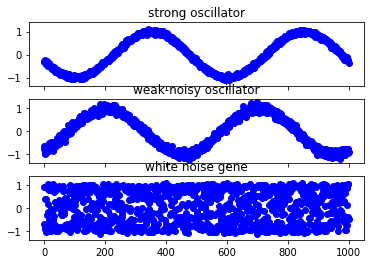

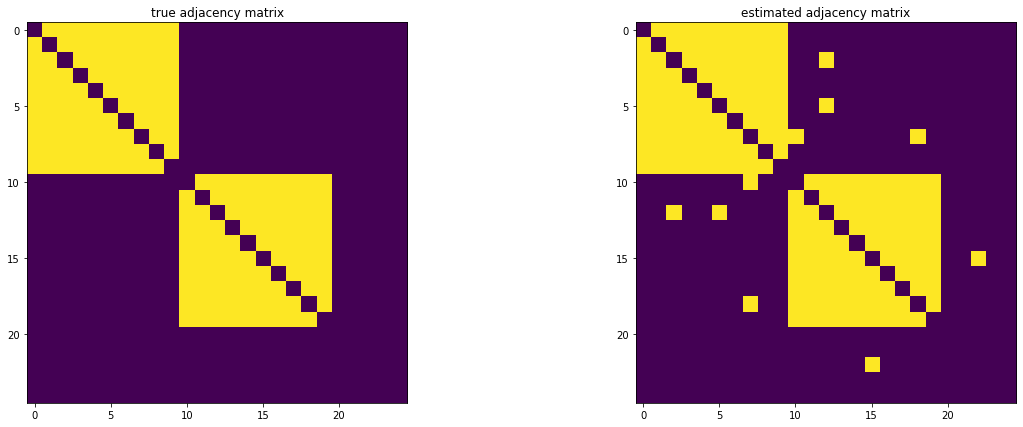

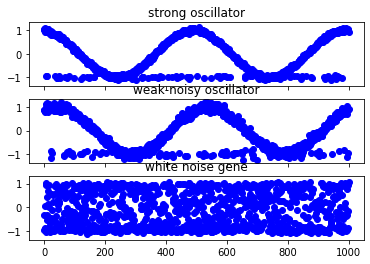

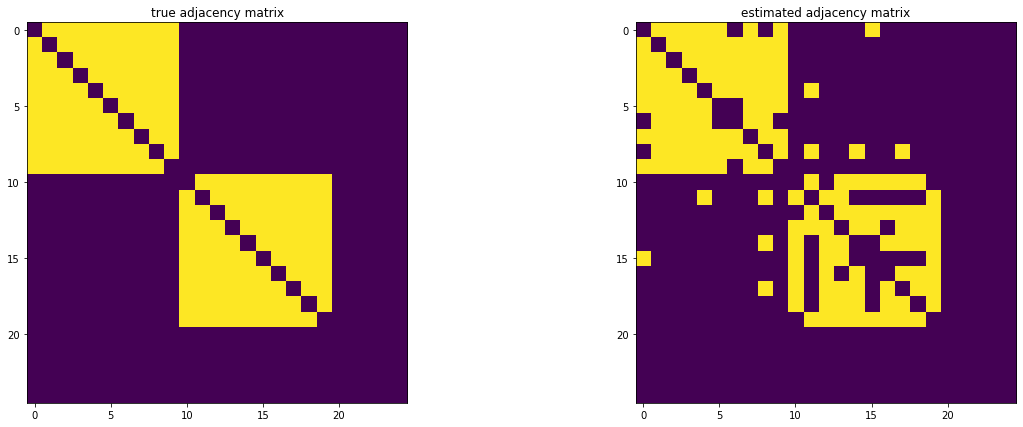

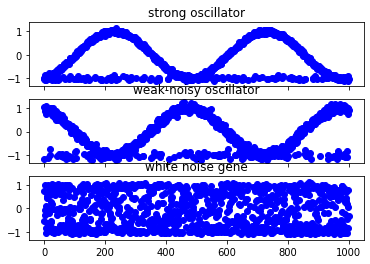

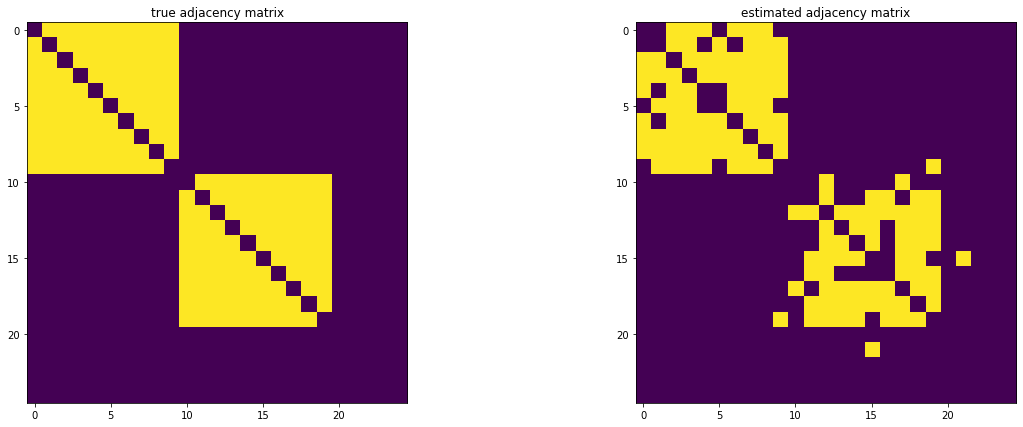

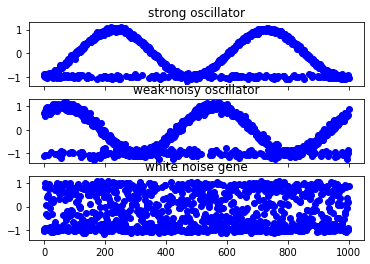

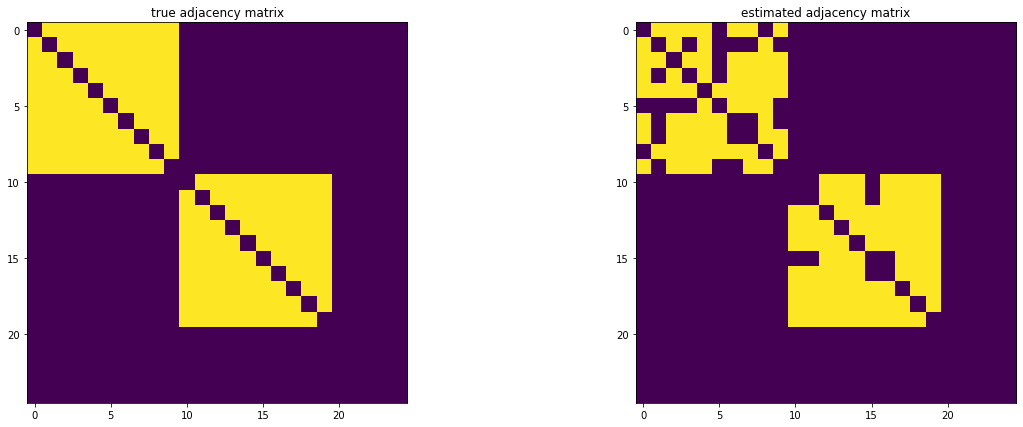

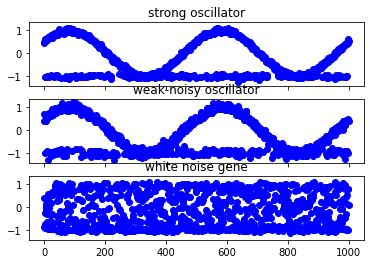

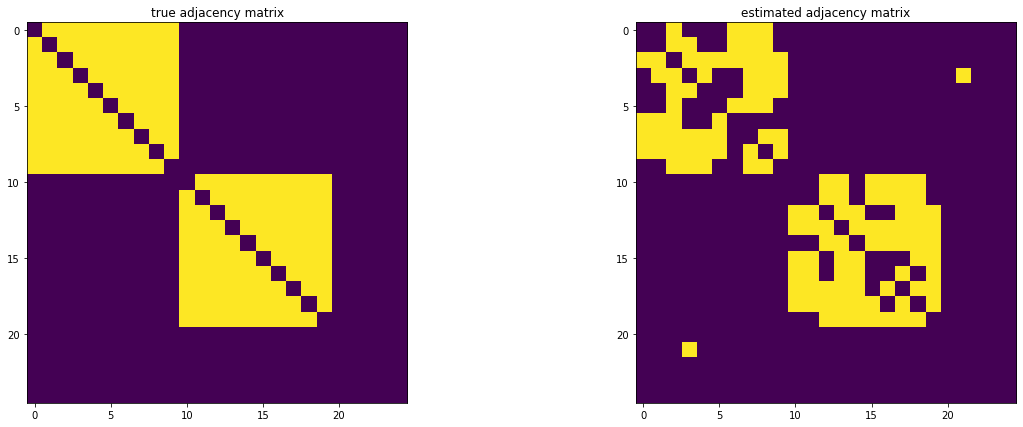

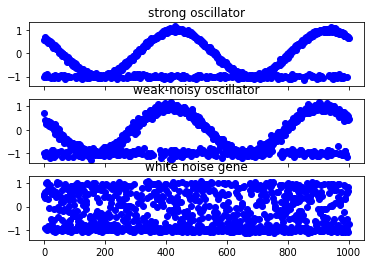

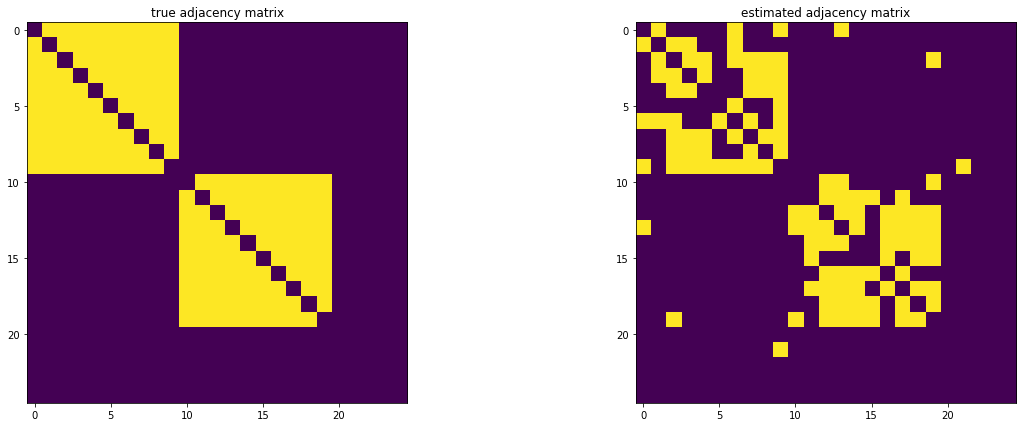

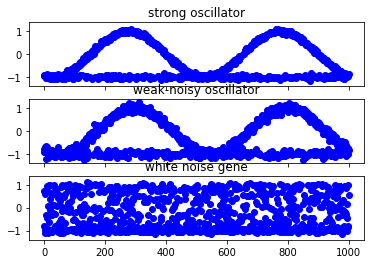

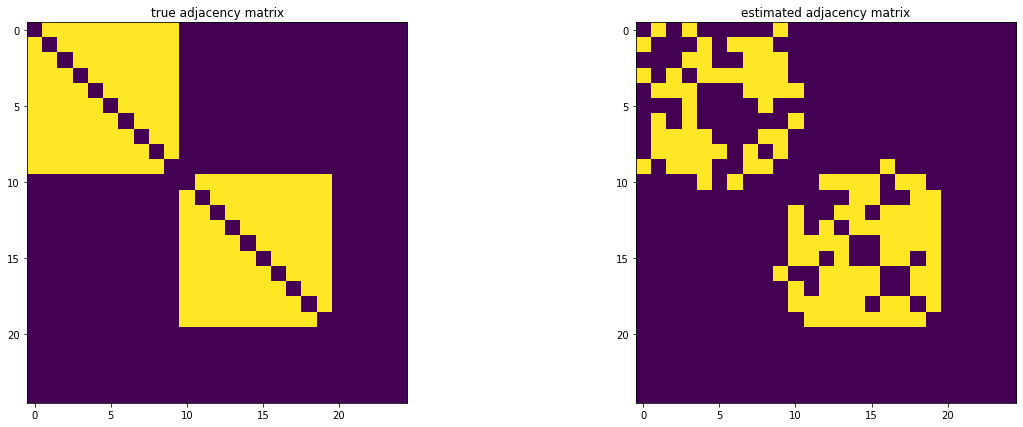

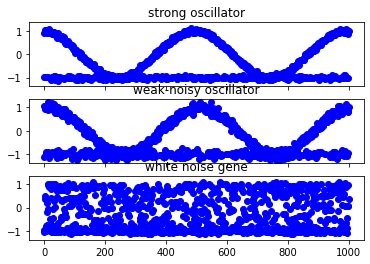

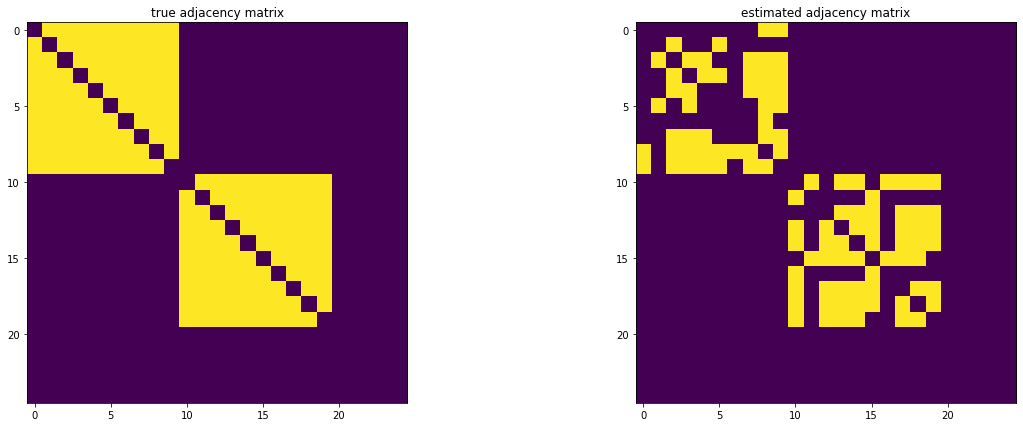

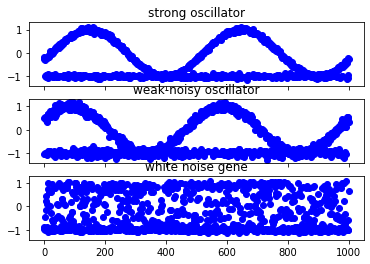

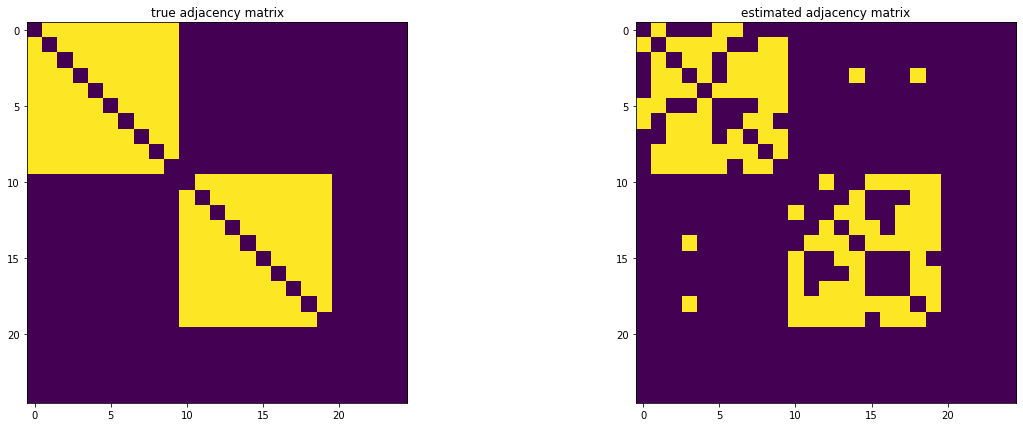

In [11]:
NG = 5  # half gene cluster size so we have a total of 10 co-oscillating genes  
G = 25 
N = 1000 # cells
ngroups = 2 # one cluster
n_bootstrap = 100  # number of bootstrap samples
grid_points_in_search = 10  # grid size for phase shift parameter estimation., 
alpha = 0.001  # significance level
#a=np.random.uniform(0,0.45,10)
#a=np.sort(a)  
a=[0,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45]
correct_ratio = np.zeros(len(a))
TPR = np.zeros(len(a))
FDR = np.zeros(len(a))

for i in range(len(a)):
    data_df, phaseG, angularSpeed = GetSimZeros(NG=NG, G=G, N=N, noiseLevel=0,a=a[i])
    adjacency_matrix, qvalues, cost_matrix = bootstrap_hypothesis_test(n_bootstrap, data_df.values, alpha=alpha,
                                                            grid_points_in_search=grid_points_in_search)
    adjacency_matrix_true = true_adj_matrix(G, angularSpeed)  # True adjacency matrix

    correct_ratio[i] = get_accuracy(adjacency_matrix, adjacency_matrix_true)
    print(f'Ratio of correctly identified pairs {correct_ratio[i]:.2f}')
    TPR[i], FDR[i], _ = get_metrics_for_different_qvalue_thresholds(qvalues, adjacency_matrix_true, np.array([alpha]))
    print(f'True positive rate {float(TPR[i]):.2f}, False discovery rate {float(FDR[i]):.2f}')
    _, ax = plt.subplots(3, sharex=True, sharey=True)
    ax[0].plot(np.arange(N), data_df.iloc[0, :], 'bo'); ax[0].set_title('strong oscillator')
    ax[1].plot(np.arange(N), data_df.iloc[0+NG, :], 'bo'); ax[1].set_title('weak-noisy oscillator')
    ax[2].plot(np.arange(N), data_df.iloc[2*NG, :], 'bo'); ax[2].set_title('white noise gene')
    _, ax = plt.subplots(1, 2, figsize=(20, 7))
    ax[0].imshow(adjacency_matrix_true); ax[0].set_title('true adjacency matrix')
    ax[1].imshow(adjacency_matrix); ax[1].set_title('estimated adjacency matrix')

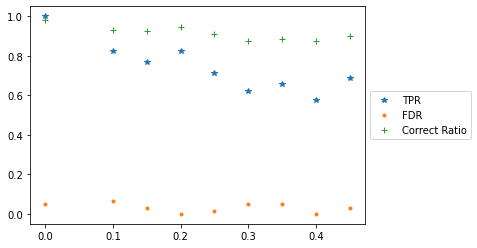

In [12]:
plt.plot(a,TPR,'*',label='TPR')
plt.plot(a,FDR,'.',label='FDR')
plt.plot(a,correct_ratio,'+',label='Correct Ratio');
legend_x = 1
legend_y = 0.5
plt.legend(loc='center left', bbox_to_anchor=(legend_x, legend_y))
#plt.legend(frameon=False)


In [15]:
print('TPR=',TPR)
print('FDR=',FDR)
print('correct_ratio=',correct_ratio)

TPR= [1.         0.82222222 0.76666667 0.82222222 0.71111111 0.62222222
 0.65555556 0.57777778 0.68888889]
FDR= [0.05263158 0.06329114 0.02816901 0.         0.01538462 0.05084746
 0.0483871  0.         0.03125   ]
correct_ratio= [0.98333333 0.93       0.92333333 0.94666667 0.91       0.87666667
 0.88666667 0.87333333 0.9       ]
